## Credit Card Fraud Detection with Synthetic Financial Datasets


Data collected from https://www.kaggle.com/ealaxi/paysim1/code

Article References: 1: Google article from Jayanta Kumar Pal - https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

                    2 : Google article from Prashant Tyagi - https://www.sqlservercentral.com/articles/model-selection-and-performance-boosting-with-k-fold-cross-validation-and-xgboost
                    
                    3 : Google article  Niklas Donges - https://builtin.com/data-science/random-forest-algorithm

In [167]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [2]:
df = pd.read_csv('C:\\Projects\\SpringBoard\\Capstone 2_Credit Card Fraud\\creditcard_preprocessing.csv')

In [3]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transactionHour,transactionPeriod
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,Mid
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,Mid


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   step               int64  
 1   type               object 
 2   amount             float64
 3   nameOrig           object 
 4   oldbalanceOrg      float64
 5   newbalanceOrig     float64
 6   nameDest           object 
 7   oldbalanceDest     float64
 8   newbalanceDest     float64
 9   isFraud            int64  
 10  isFlaggedFraud     int64  
 11  transactionHour    int64  
 12  transactionPeriod  object 
dtypes: float64(5), int64(4), object(4)
memory usage: 631.1+ MB


###### Origin Error Balance in Amount

  - The below cell explains the error in origin account balance amount after transaction (outgoing transaction)

      - Error = (New Balance + Transaction Amount) - Old Balance
      - prove that the old and new balance in origin account are zero

In [5]:
df["errorBalanceOrig"]= df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

In [6]:
# flag to indicate whether both oldbalanceOrg and newbalanceOrig in origin account are zero
df['zeroBalanceOrig'] = df['oldbalanceOrg'] + df['newbalanceOrig']
df['zeroBalanceOrig'] = df['zeroBalanceOrig'].apply(lambda x: 1 if x == 0 else 0)

######  Destination Error Balance in Amount

  - The below cell explains the error in destination account balance amount after transaction (outgoing transaction)

      - Error = Error = (Old Balance + Transaction Amount) - New Balance
      - prove that the old and new balance in destination account are zero

In [7]:
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [8]:
# flag to indicate whether both old and new balance in destination account are zero
df['zeroBalanceDest'] = df['oldbalanceDest'] + df['newbalanceDest']
df['zeroBalanceDest'] = df['zeroBalanceDest'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
print(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M').any())
print(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M').any())
print((df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())
print(df.loc[df.type == 'TRANSFER'].nameDest.str.contains('M').any())

False
False
False
False


Observations:

Merchant accounts are not included in the fraudulent Transactions and it is only identified in 'PAYMENT' type transactions.

In [10]:
# subsetting fraudulent transactions
is_fraud = df[df['isFraud'] == 1].drop(columns=['isFlaggedFraud'])

# subsetting non-fraudulent transactions
not_fraud = df[(df['isFraud'] == 0) & (df['type'].isin(['CASH_OUT','TRANSFER']))].drop(columns=['isFlaggedFraud'])
# creating a new dataframe from sub-sampled data
df_new = pd.concat([is_fraud, not_fraud], axis=0)
df_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,transactionHour,transactionPeriod,errorBalanceOrig,zeroBalanceOrig,errorBalanceDest,zeroBalanceDest
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,1,Mid,0.0,0,181.0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,1,Mid,0.0,0,21363.0,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,1,Mid,0.0,0,2806.0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1,Mid,0.0,0,29008.0,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,1,Mid,0.0,0,20128.0,1


In [11]:
df_new.iloc[:,1].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)


   ### Train/Test Split

####  Split the data into test and train subsamples

 - Before the model development, split the data into train and test samples.

In [12]:
X = df_new.drop(columns=['isFraud', "nameOrig", "nameDest"])
y = df_new['isFraud']


In [13]:
X.type.replace(to_replace=dict(TRANSFER=1, CASH_OUT=0), inplace=True)

In [14]:
X.transactionPeriod.replace(to_replace=dict(Mid=0, Peak=1,Safe=2 ), inplace=True)

 leave out some data (for testing) and train the model on the rest
  - Split the data into a training and test (hold-out) set


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2216327, 13), (554082, 13), (2216327,), (554082,))

In [16]:
y_test

2650057    0
4800233    0
3770686    0
5115227    0
6052360    0
          ..
2553954    0
836797     0
1142115    0
1278848    0
2860445    0
Name: isFraud, Length: 554082, dtype: int64

In [17]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

step                   int64
type                   int64
amount               float64
oldbalanceOrg        float64
newbalanceOrig       float64
oldbalanceDest       float64
newbalanceDest       float64
transactionHour        int64
transactionPeriod      int64
errorBalanceOrig     float64
zeroBalanceOrig        int64
errorBalanceDest     float64
zeroBalanceDest        int64
dtype: object

In [18]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

step                   int64
type                   int64
amount               float64
oldbalanceOrg        float64
newbalanceOrig       float64
oldbalanceDest       float64
newbalanceDest       float64
transactionHour        int64
transactionPeriod      int64
errorBalanceOrig     float64
zeroBalanceOrig        int64
errorBalanceDest     float64
zeroBalanceDest        int64
dtype: object

## Modelling 

  ###  Model 1 : Random Forest Classifier
  
  Random Forest builds with ensemble of multiple decision trees and  usually trained with the “bagging” method. Here we use  random forest in classification problem. 
   - Bagging is called the Bootstrap Aggregation.
   - The base learner is Decision Tree
   - Each tree build from Bootstrap sample.
   - It is used to investigate the importance of the feature with a large data set.
   - Take the raw sampling and feature sampling to the decision tree to train the data.
      - Training done in parellel.
   - Using unweighted voting for final prediction
   - Easier to tune and harder to overfit.
   

Normally scaling is not required for Random Forest classifier as it is Decision Tree based algorithm. But In our first case I am trying to predict the value with scaled data.

In [19]:
# build scaler based on training data and apply it to test data to then also scale the test data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=1.000
Random Forest: f1-score=1.000


In [154]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[552453      1]
 [    12   1616]]
0.9999765377687779
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



#### Hyperparameter tuning

 
   ####   Manual Hyperparameter Tuning
 
 - Increasing the predictive power
    - n_estimators : number of trees the algorithm builds before taking the maximum voting or taking the averages of predictions.
    - max_features : maximum number of features random forest considers to split a node.
 - Increasing the model's speed
    - n_jobs : The n_jobs hyperparameter tells the engine how many processors it is allowed to use. If it has a value of one, it can only use one processor. A value of “-1” means that there is no limit.
    - random_state : hyperparameter makes the model’s output replicable
    - The minimum number of samples required to be at a leaf node

In [25]:
### Manual Hyperparameter Tuning
model=RandomForestClassifier(n_estimators=300,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=10,random_state=100).fit(X_train_scaled,y_train)
predictions=model.predict(X_test_scaled)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[552452      2]
 [    12   1616]]
0.9999747329817609
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



 In all the cases we get 99.99% accuracy.

As we got good accuracy with Manual method, RandomizedSearchCV is not performed

###  Model 2: XgBoost Classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.
Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems. Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models.

The XGBoost model for classification is called XGBClassifier. We can create and and fit it to our training dataset. Models are fit using the model.fit() function.

Parameters for training the model can be passed to the model in the constructor.

In [96]:
# Fitting XGBoost to the Training set
import xgboost
classifier = xgboost.XGBClassifier()
classifier.fit(X_train, y_train)

C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:32:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

We can make predictions using the fit model on the test dataset.

 Now that we have used the fit model to make predictions on new data, we can evaluate the performance of the predictions by comparing them to the expected values. For this we will use the built in accuracy_score() function in scikit-learn.


In [97]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
predictions = [round(value) for value in y_pred]

In [98]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [100]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[552454      0]
 [    10   1618]]


k-Fold Cross Validation is used to evaluate our machine learning model. It can also be used to improve the performance of the model by Parameter Tuning techniques like Random Search or Grid Search.

k-Fold Cross Validation:

  - helps us with model evaluation finally determining the quality of the model.
  - is crucial to determining if the model is generalizing well to data.
  - checks if the model is overfitting or underfitting.
  - lets us choose the model which had the best performance.

In [39]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()

C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:00:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

6.7529016384357624e-06

In [41]:
print(accuracies.mean())
print(accuracies.std())

0.9999882688766528
6.7529016384357624e-06


Here we Performed k-fold cross validation on the training set and made the final evaluation of selected model on the test set.


### Hyperparameter Optimization For XgBoost using RandomizedSearchCV

We will use RandomizedSearchCV for hyperparameter optimization. It basically works with various parameters internally and finds out the best parameters that XGBoost algorithm can work better with.

Create a dictionary of some parameters to be trained. Here the keys are basically the parameters and the values are a list of values of the parameters to be trained upon. So the RandomizedSearchCV will test each value and find out the particular value which gives the highest accuracy.

In [101]:
## Hyper Parameter Optimization
# Build the best parameters.

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [43]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [45]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [46]:
classifier=xgboost.XGBClassifier()

 Next, we call the RandomizedSearchCV() and pass the following parameters as below:
 
 - classifier : Default instance of XGBoost classifier
 - param_distributions : parameters to be passed
 - scoring : scoring attribute
 - n_iter : Number of iterations
 - n_jobs : Number of cores to be used(-1 indicates all the cores)
 - cv : cross validation
 - verbose : To generate messages while training the model

In [47]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [49]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X,y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 39.0min finished
C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 41 minutes and 34.7 seconds.


In [50]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [51]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 6,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

 Now we know all the best parameters. So, we can simply build our final classifier model by passing all those parameters.

In [54]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=7, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Now, we will find the cross validation score of our above model using cross_val_score. 
 - Here we will get 10 different accuracies, as we have cv = 10

In [56]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X,y,cv=10)

C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [57]:
score

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [58]:
score.mean()

0.9999841178742497

 Finally, if we see the mean of the accuracies, we get an accuracy of 99.99%.  This is how we perform hyperparameter tuning in XGBoost

### Model 3: Logistic Regression

There are different ways of making classifications. 
  - Train on the training set, and test for accuracy on the testing set
  - Logistic regression is mainly used to solve Binary classification problem and when the dependent variable is catogorical.
  - This binary logistic classification problem should be linearly Seperable.
  


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))


0.9968957663306153


#### Tuning the Model

The model has some hyperparameters we can tune for better performance. For tuning the parameters of our model, we will use a mix of cross-validation and grid search. In Logistic Regression, the most important parameter to tune is the regularization parameter 'C'. The regularization parameter is not always part of the logistic regression model.
   
  #### Case 1:
  
  - We use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. Here we use accuracy score as the default scoring function.
 

In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, X, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X_train, y_train) # fit
        result += score_func(clf.predict(X_train), y_train) # evaluate score function on held-out data
    return result / nfold # average

In [65]:
clf = LogisticRegression()
score = cv_score(clf, X_train, y_train)
print(score)

0.9969111056265614


The below is the cv_score function for a basic logistic regression model without regularization.

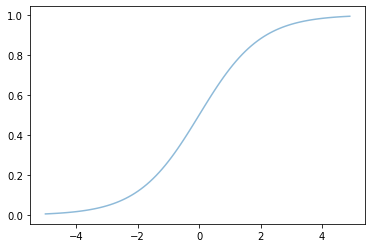

In [90]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

  #### Case 2:
   Now perform model tuning and selecting the regularization parameter 'C' in classification.

For each C:

  - Create a logistic regression model with that value of C
   - Pick the C with the accuracy_score

In [91]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]


from sklearn.metrics import accuracy_score

for C in Cs:
    logreg = LogisticRegression(C=C)
     
   
logreg = LogisticRegression(C=C)
logreg.fit(X_train, y_train)
ypredlr = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9999819521298292


Here, in the above model, we estimated how this model will predict on unseen data.

  - Used the C value in the procedure and train a Logistic Regression on the training data


### Case 4:  Decision Tree Entropy model - max depth 3

In [120]:
from sklearn import tree, metrics
entr_model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state = 1234)
entr_model.fit(X_train, y_train)
y_pred = entr_model.predict(X_test)
y_pred = pd.Series(y_pred)
entr_model

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1234)

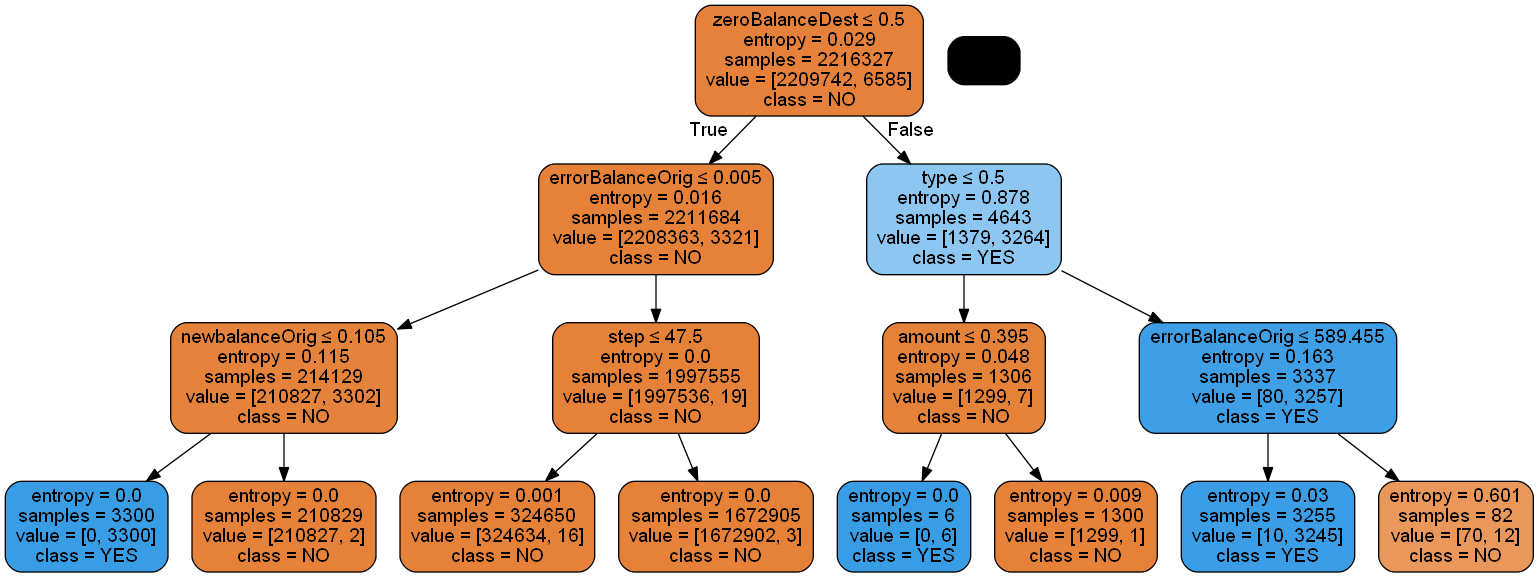

In [121]:
 #we need to visualize the tree to grasp its nature
from io import StringIO 
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
tree.export_graphviz(entr_model, out_file=dot_data, 
                     filled=True, rounded=True, 
                     special_characters=True, feature_names=X_train.columns, class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [122]:
# Run this block for model evaluation 
print("Model Entropy model max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))


Model Entropy model max depth 3
Accuracy: 0.9999639042596583
Balanced accuracy: 0.9953885951294785


### Case 4 A:  Decision Tree Gini model - max depth 3

In [123]:
# As before, make a variable, but call it gini_model2, and ensure the max_depth parameter is set to 3
gini_model = tree.DecisionTreeClassifier(criterion ='gini', random_state = 1234, max_depth  = 3)

# Do the fit, predict, and series transformations as before. 
gini_model.fit(X_train, y_train)
y_pred = gini_model.predict(X_test)
y_pred = pd.Series(y_pred)
gini_model

DecisionTreeClassifier(max_depth=3, random_state=1234)

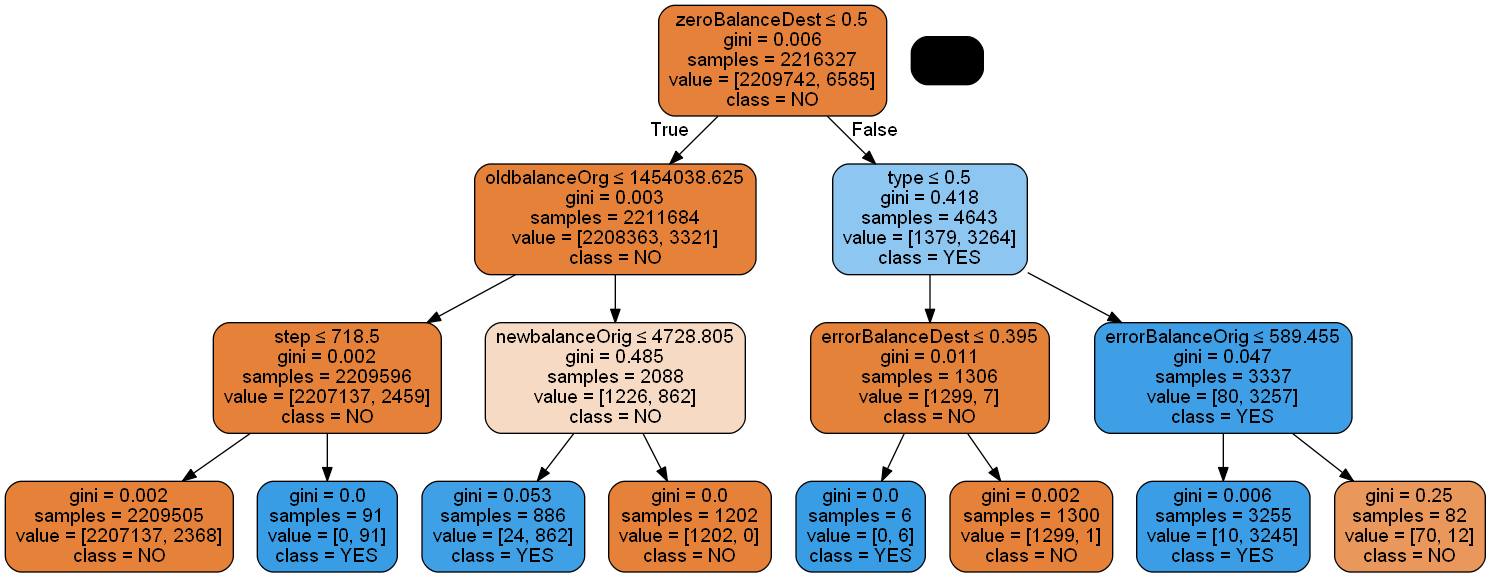

In [124]:
dot_data = StringIO()
tree.export_graphviz(gini_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns, class_names = ["NO", "YES"])


# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [126]:
print("Gini impurity  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))


Gini impurity  model - max depth 3
Accuracy: 0.9989135182157154
Balanced accuracy: 0.8166416663825498


### Case 5: Gradient Boosting

In [127]:
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

Run the cell below to test multiple learning rates in gradient boosting classifier.

In [128]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 3, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.998
Accuracy score (validation): 0.998

Learning rate:  0.1
Accuracy score (training): 0.999
Accuracy score (validation): 0.999

Learning rate:  0.25
Accuracy score (training): 0.999
Accuracy score (validation): 0.999

Learning rate:  0.5
Accuracy score (training): 0.999
Accuracy score (validation): 0.999

Learning rate:  0.75
Accuracy score (training): 0.993
Accuracy score (validation): 0.993

Learning rate:  1
Accuracy score (training): 0.858
Accuracy score (validation): 0.858



#### Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.

In [135]:
gb2 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.25, max_features=2, max_depth = 3, random_state = 0)

gb2.fit(X_train, y_train)
predictions = gb2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[552292    162]
 [   403   1225]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       0.88      0.75      0.81      1628

    accuracy                           1.00    554082
   macro avg       0.94      0.88      0.91    554082
weighted avg       1.00      1.00      1.00    554082



In [164]:
Pipeline = Pipeline([
    ('sampler',RandomUnderSampler(random_state=1234,sampling_strategy='majority')),
    ('clf',GradientBoostingClassifier(max_features='sqrt',subsample=0.7))
    ])
params = {'clf__learning_rate':[0.5,0.25],
              'clf__n_estimators':[300,500],
              'clf__max_depth':[3]
    }

cv = GridSearchCV(Pipeline,params,scoring="roc_auc",verbose=True,n_jobs=-1)
cv.fit(X_train,y_train)
print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   52.9s finished


{'clf__learning_rate': 0.25, 'clf__max_depth': 3, 'clf__n_estimators': 300}
0.9990875647779353


### Model Performance

#### F1 Score and Accuracy Score comparison

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is usually more useful than accuracy Score. 


In [165]:
from sklearn.metrics import f1_score,classification_report,roc_auc_score
print(f"F1 score of decision tree classifier - gini_model is {f1_score(gini_model.predict(X_test),y_test)}")
print(f"F1 score of decision tree classifier - Entropy model is {f1_score(entr_model.predict(X_test),y_test)}")
print(f"F1 score of GBM classifier is {f1_score(cv.best_estimator_.predict(X_test),y_test)}")
print(f"F1 score of logistic regression classifier is {f1_score(logreg.predict(X_test),y_test)}")
print(f"F1 score of XgBoost classifier is {f1_score(classifier.predict(X_test),y_test)}")
print(f"F1 score of Random Forest classifier is {f1_score(y_test, y_pred, average='weighted')}")

print(f"AUC of decision tree classifier- gini_model is {roc_auc_score(gini_model.predict(X_test),y_test)}")
print(f"AUC of decision tree classifier - Entropy model is {roc_auc_score(entr_model.predict(X_test),y_test)}")
print(f"AUC of GBM classifier is {roc_auc_score(cv.best_estimator_.predict(X_test),y_test)}")
print(f"AUC of logistic regression classifier is {roc_auc_score(logreg.predict(X_test),y_test)}")
print(f"AUC of XgBoost classifier is {roc_auc_score(classifier.predict(X_test),y_test)}")
print(f"AUC of Random Forest is {roc_auc_score(rf_classifier.predict(X_test),y_test)}")

F1 score of decision tree classifier - gini_model is 0.7740240240240239
F1 score of decision tree classifier - Entropy model is 0.9938385705483671
F1 score of GBM classifier is 0.7557109557109557
F1 score of logistic regression classifier is 0.4462330972311655
F1 score of XgBoost classifier is 0.9969192852741837
F1 score of Random Forest classifier is 0.9987930889252933
AUC of decision tree classifier- gini_model is 0.9970471344819049
AUC of decision tree classifier - Entropy model is 0.9984413070258815
AUC of GBM classifier is 0.8044639758164435
AUC of logistic regression classifier is 0.73359243571112
AUC of XgBoost classifier is 0.9999909496365373
AUC of Random Forest is 0.9996799249885742


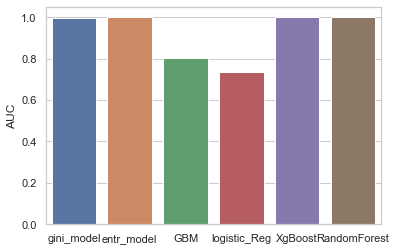

In [166]:
sns.set_theme(style="whitegrid")
sns.barplot(x=["gini_model", "entr_model", "GBM", "logistic_Reg", "XgBoost", "RandomForest"],
            y=[roc_auc_score(gini_model.predict(X_test),y_test), roc_auc_score(entr_model.predict(X_test),y_test), roc_auc_score(cv.best_estimator_.predict(X_test),y_test), roc_auc_score(logreg.predict(X_test),y_test),
               roc_auc_score(classifier.predict(X_test),y_test), roc_auc_score(rf_classifier.predict(X_test),y_test)])
plt.ylabel("AUC")
plt.show()

### Summary:
    
- XgBoost, Random Forest and Decision Tree are performing well and gives us the best estimation.
   - The best model is XgBoost classification Algorithm with 99.99% performance.
   

- We have performed the  hyperparameter tuning techniques to handle the quantitative variables in a better manner (XgBoost and Random Forest)
- performed model tuning and selected the regularization parameter 'C' in Logistic Regression classification algorithm.

